## Question 2: Applied ML

In [55]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

#### 1. Loading of dataset, TF-IDF, seperation of training, testing and validation sets
We load the 20newsgroup dataset using sklearn. Since we are going to create ourselves the traning, testing and validation datasets from the entire datasets, we load the entire newsgroup and not only the train subset as proposed in the proposed tutorial. Also, we load the dataset without the metadata, namely without the headers, footers and quotes as it is recommended by the tutorial. That way, the data from texts can be studied without being masked by too frequent metadata such as the sender's affiliated university.

In [4]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


We use the TfidfVectorizer function to compute TF-IDF features for every article. 

In [67]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
# this allows us to have an idea of the number of words for which the TF-IDF is computed for the articles
vectors.shape

(11314, 101322)

There are 101322 TF-IDF features computed for 11314 articles.

In [68]:
vectors.nnz / float(vectors.shape[0])

66.802987449178

It was not asked by the exercise but we notice that vectors are quite sparse because there is an average of 66.8 out of 101322 non zero entries by vector.

We now split our dataset into a training (80%), a testing (10%) and a validation (10%) set. We use the train_test_split function and procede in two steps. First we seperate the whole set into the training set and a temporary set from which we then create the testing and validation sets. Each observation is paired with its corresponding label (the article category).

In [69]:
#We seperate the training dataset from the rest, as a result we obtain the TF-IDF vectors belonging 
#to the training vectors as well as their corresponding label, namely the nesgroups targets. 
#We choose to use random_state=None as it means it will use np.random thus the training set is picked randomly.
labels_training, labels_tmp, vectors_training, vectors_tmp = train_test_split(newsgroups.target, vectors, test_size=0.2, random_state=None)

#We now seperate the tmp set with corresponding labels randomly in half to obtain the testing and validation sets
labels_testing, labels_validation, vectors_testing, vectors_validation = train_test_split(labels_tmp, vectors_tmp, test_size=0.1, random_state=None)

#### 2. Training of random forest, fine tuning of predictor on validation set, model assessment and discussion

We train a random forest on our training set.

In [70]:
clf = RandomForestClassifier()

We perform a grid search to fine tune the n_estimators and max_depth parameters by finding the best classifier accuracy on the validation set.

In [31]:
def grid_search(n_estimators_list, max_depth_list):
    score=0
    final_depth=0
    final_estimator=0
    for depth in max_depth_list:
        for n_estim in n_estimators_list:
            classifier=RandomForestClassifier(max_depth=depth, n_estimators=n_estim, random_state=None)
            classifier.fit(vectors_training, labels_training)
            prediction = classifier.predict(vectors_validation)
            scoring = metrics.accuracy_score(labels_validation, prediction)
            if scoring > score:
                score=scoring
                final_depth=depth
                final_estimator=n_estim
    return (score, final_depth, final_estimator)

In [32]:
grid_search([50,100,200,500,1000,1500,2000,2500], [1,10,20,30])

(0.65198237885462551, 30, 2500)

According to our grid search, we should use the Random Forest classifier with max_depth=30 and n_estimators=2500

In [71]:
classifier=RandomForestClassifier(max_depth=30, n_estimators=2500, random_state=None)
classifier.fit(vectors_training, labels_training)
prediction = classifier.predict(vectors_validation)

We compute a confusion matrix of our classification pipeline and use the proposed function to plot it available as an example on the scikit-learn website.

In [72]:
prediction = classifier.predict(vectors_testing)

In [46]:
#function found on scikit-learn to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


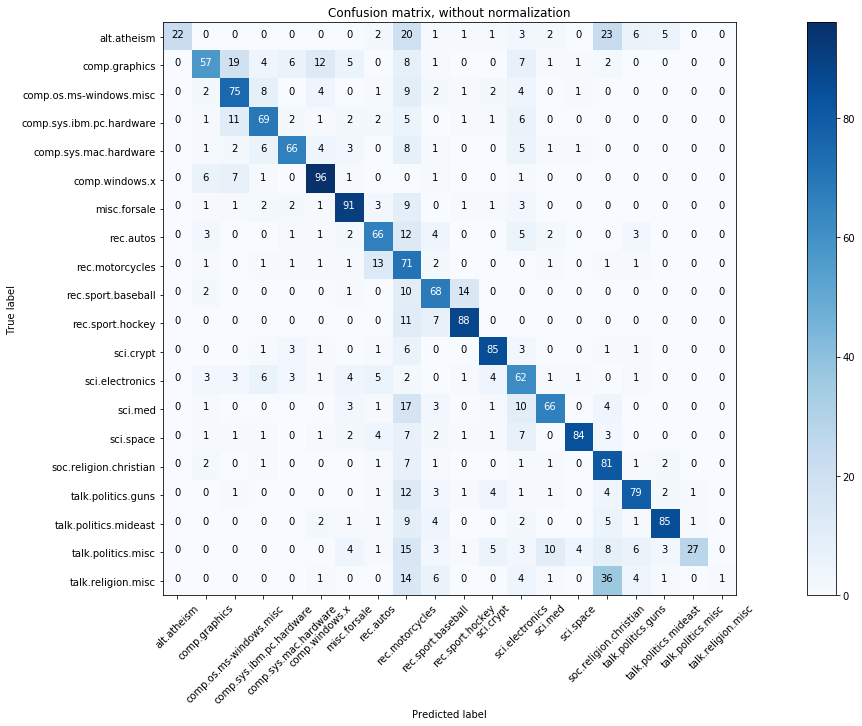

In [47]:
# Compute confusion matrix
confusion = confusion_matrix(labels_testing, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(confusion, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


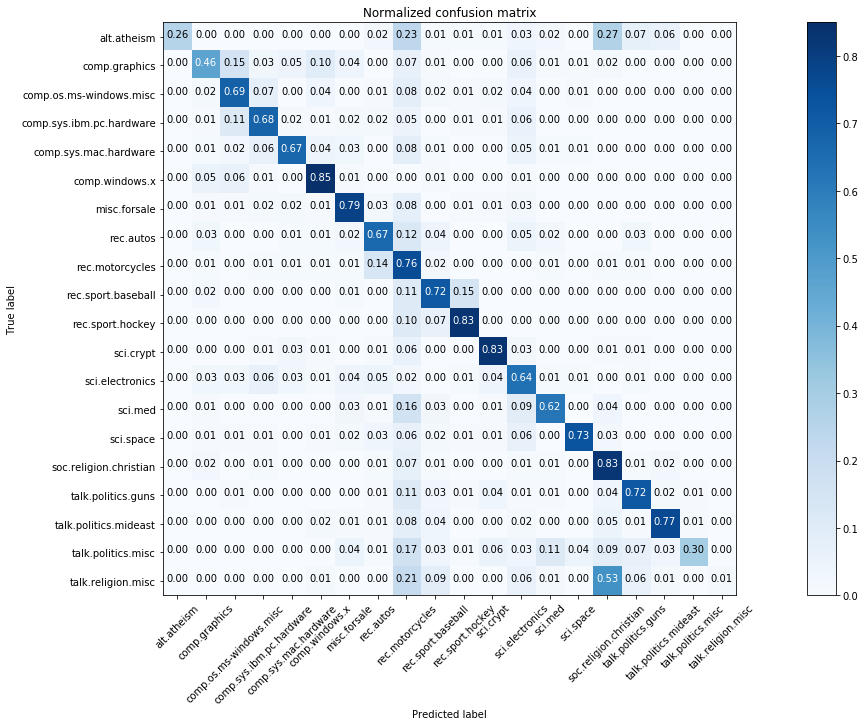

In [49]:
# Plot normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(confusion, classes=newsgroups.target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Finally, we inspect the `feature_importances_` attribute of our random forest and discuss the obtained results.

In [83]:
sorted_index = np.argsort(classifier.feature_importances_)
best10 = sorted_index[-1:-11:-1]
features = np.array(vectorizer.get_feature_names())[best10]
importances = classifier.feature_importances_[best10]

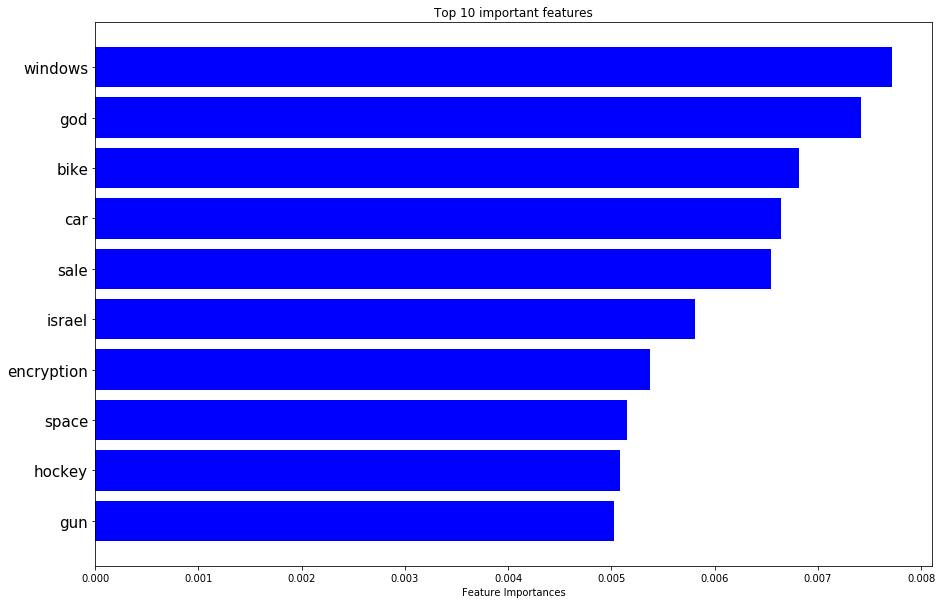

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(features, size = 15)
ax.invert_yaxis()  
ax.set_xlabel('Feature Importances')
ax.set_title('Top 10 important features')
plt.show()